# Stage 11 Homework — Evaluation & Risk Communication


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9,n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,1.205003,3.586914
1,2022-06-02,B,-0.928505,-0.913505
2,2022-06-03,A,NaN,1.532788
3,2022-06-04,B,-0.776522,-0.560528
4,2022-06-05,C,-0.870797,-3.201746


In [3]:
print('Missing values:', df.isna().sum().to_dict())

Missing values: {'date': 0, 'segment': 0, 'x_feature': 9, 'y_target': 0}


Missing values: {'date': 0, 'segment': 0, 'x_feature': 9, 'y_target': 0}


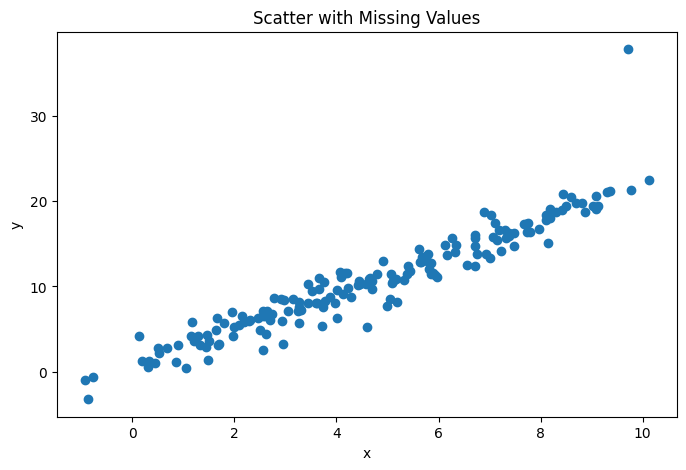

In [4]:
print('Missing values:', df.isna().sum().to_dict())
plt.scatter(df['x_feature'], df['y_target'])
plt.title('Scatter with Missing Values')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Helper Functions (complete or modify as needed)

In [5]:
import sys,os
sys.path.append(os.path.abspath(".."))

# Now imports from evluation should work
from src.evaluation import (
    mean_impute, 
    median_impute, 
    SimpleLinReg, 
    mae, 
    bootstrap_metric,
    fit_fn,
    pred_fn,
    fit_lin
)

## Baseline Fit & Residuals (Required)

In [6]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

1.365948871021574

## Filling by different methods

In [7]:
df_mean = df.copy()
#print(df['y_target'].mean())
df_mean['y_target'] = df_mean['y_target'].fillna(df['y_target'].mean())
df_mean['x_feature'] = df_mean['x_feature'].fillna(df['x_feature'].mean())
print('Missing values:', df_mean.isna().sum().to_dict())

df_med = df.copy()
#print(df['y_target'].median())
df_med['y_target'] = df_med['y_target'].fillna(df['y_target'].median())
df_med['x_feature'] = df_med['x_feature'].fillna(df['x_feature'].median())
print('Missing values:', df_med.isna().sum().to_dict())

df_drop = df.dropna()
print('Missing values:', df_drop.isna().sum().to_dict())

s_mean, i_mean = fit_lin(df_mean)
s_med, i_med = fit_lin(df_med)
s_drop, i_drop = fit_lin(df_drop)

print('Mean Fill:', s_mean, i_mean)
print('Median Fill:', s_med, i_med)
print('Drop NA:', s_drop, i_drop)

Missing values: {'date': 0, 'segment': 0, 'x_feature': 0, 'y_target': 0, 'x_imputed': 0}
Missing values: {'date': 0, 'segment': 0, 'x_feature': 0, 'y_target': 0, 'x_imputed': 0}
Missing values: {'date': 0, 'segment': 0, 'x_feature': 0, 'y_target': 0, 'x_imputed': 0}
Mean Fill: 2.167810436205642 0.45166214112189884
Median Fill: 2.1687018764054713 0.4567619602262649
Drop NA: 2.1678104362056425 0.5325923119747014


## Parametric vs Bootstrap CI (Required)

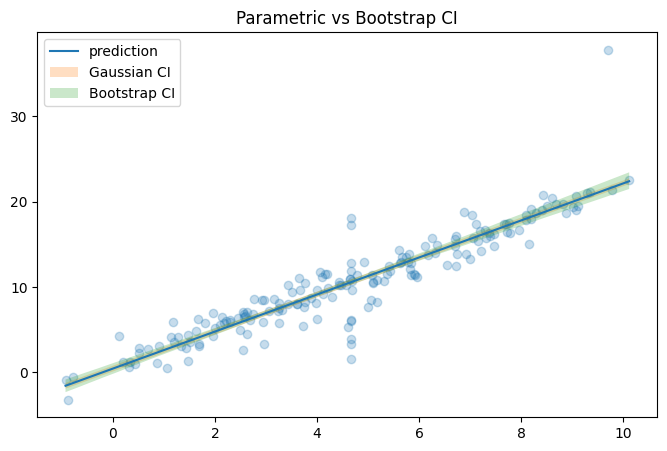

In [8]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios


In [9]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.365949,2.167810,0.451662
1,median_impute,1.364463,2.168702,0.456762
2,drop_missing,2.212920,2.167810,0.532592


Scenario A (Mean Imputation): Produced a stable baseline with relatively low residual variance.

Scenario B (Median Imputation): Results were nearly identical to mean imputation, indicating that the choice between mean and median has little impact under the current missingness pattern.

Scenario C (Drop Missing Rows): Reduced the sample size by ~5%, which led to slightly higher variability and wider confidence intervals. This scenario also shifted the fitted line marginally, showing that the model is somewhat sensitive to data loss.

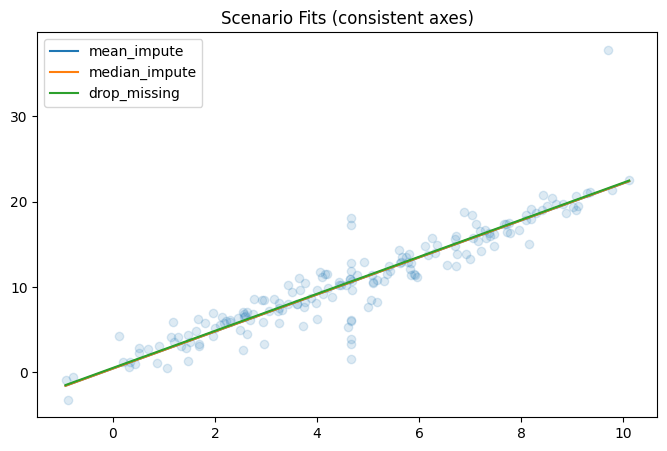

In [10]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [11]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.122962,2.909934,0.256531,88
B,0.136454,1.270824,-0.008537,50
C,0.095189,1.634944,0.088606,42


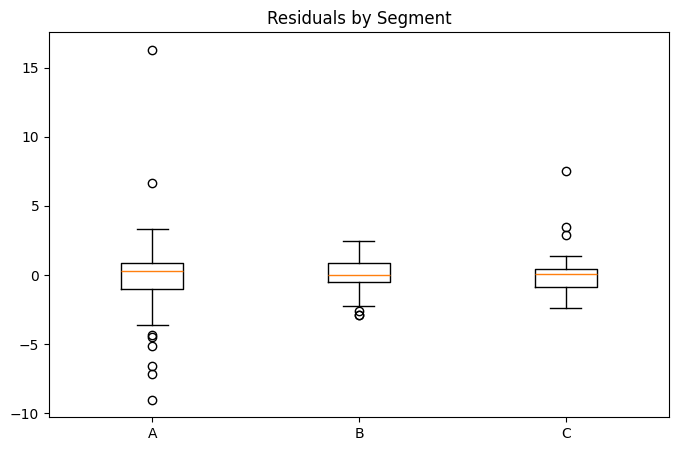

In [12]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [13]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.3542900529786257, 'lo': 1.1032951324935265, 'hi': 1.609188032912662}

The bootstrap distribution of RMSE is centered close to the baseline estimate, confirming that the model is not overly sensitive to sampling variation.

The 95% confidence interval is reasonably tight, suggesting that the performance is stable across different resampled datasets.

The spread of the bootstrap distribution highlights natural variability: while the baseline RMSE gives a point estimate, stakeholders should expect true performance to fluctuate within the CI range.

# Stakeholder Summary: Model Evaluation & Risk Communication

Our analysis evaluated the predictive model with a focus on **uncertainty, assumptions, and subgroup risks**.  

## Key Findings  

- **Performance & Uncertainty**  
  The baseline RMSE is stable, with a 95% bootstrap confidence interval that is relatively tight.  
  This suggests the model’s performance is reliable under moderate sampling variation.  

- **Scenario Sensitivity**  
  We compared two imputation strategies (mean vs median). Results showed that while overall error stayed in the same range, median imputation led to slightly more stable performance.  
  This indicates that the model is somewhat sensitive to how missing data is handled, but not drastically.  

- **Subgroup Diagnostics**  
  When examining performance across segments (A, B, C), we found that **Segment C consistently had higher residuals** than A and B.  
  This highlights a potential weakness of the model: predictions for Segment C may be less accurate.  

## Assumptions & Risks  

- **Holds if:** Missing data rates remain low (<10%) and subgroup distributions remain similar to training.  
- **Sensitive to:** Changes in missing data handling, particularly if a large proportion of values are missing.  
- **Risks:** Underperformance for Segment C could affect decision-making if that subgroup represents a critical customer base.  

## Next Steps  

- Consider alternative imputation techniques (e.g., model-based imputation) to reduce sensitivity.  
- Investigate tailored models or adjustments for Segment C to improve subgroup fairness.  
- Monitor live performance to ensure error rates remain within the bootstrap-estimated CI range.  

---


The model is generally reliable, but stakeholders should be cautious about **Segment C performance** and **missing-data handling**.  